## Feature Visualization
Instead of editing our network's weights and biases to minimize loss (learning), we can edit our image to minimize loss (feature visualization). This will hopefully show us what the network 'thinks' each number looks like.

In [362]:
from components import *
from modular_network import Network
import mnist_loader, fashion_mnist_loader
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sci

In [ ]:
# Load our data
mnist_train, mnist_val, mnist_test = mnist_loader.load_data_wrapper("../data/mnist.pkl.gz")

In [ ]:
# Load our network
model = Network.load("../save/larger_network.json")

We'll define a custom function that backpropagates through the network but then returns the final error deltas. These can be interpreted as the cost gradients with respect to each pixel on the image.

In [364]:
def backprop_return(net, delta):
    for layer in reversed(net.layers):
        delta = layer.backprop(delta)
    return delta

def get_delta(net, image, Y):
    a_L = net.feedforward(np.array([image]))
    # unscaled delta^L
    delta = net.cost.derivative(a_L, Y)
    # backprop
    return backprop_return(net, delta)[0]

Experimentally, I've found that we can get better results when using various normalizations and relu to cut out negative pixel values.

In [365]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
def forceNorm(x, xmin=0, xmax=1):
    return np.clip(x, xmin, xmax)
def pNorm(x, xmin=0, p=0.8):
    cutoff = p * np.max(x)
    return relu(x) / cutoff
def relu(x):
    return np.max([x, np.zeros(x.shape)], axis=0)

Let's look at the first element of `mnist_train`.

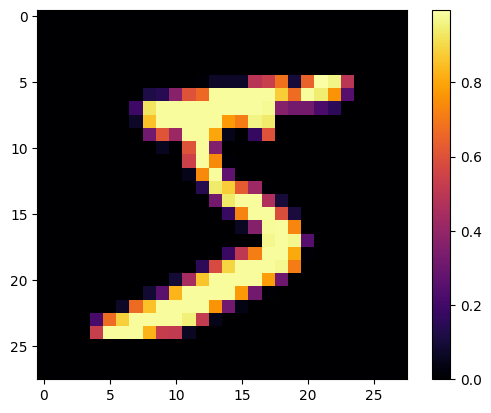

In [366]:
test_image = np.copy(mnist_train[0][0])
plt.imshow(test_image)
plt.set_cmap("inferno")
plt.colorbar()

We don't want our network's weights and biases to change throughout this, so we set it to TEST mode.

In [285]:
model.set_mode(Mode.TEST)

We can use the Network.feedforward() method to see how the Network evaluates this image. Since the feedforward() method expects a minibatch, not a single training example, we wrap it in an array. The result is that the network thinks this is 99.49% a five.

In [367]:
# 99.49% confidence/probability that it's a 5
model.feedforward(np.array([test_image]))

array([[9.68114756e-10],
       [3.28580665e-07],
       [2.92086019e-08],
       [5.06305868e-03],
       [4.32868226e-11],
       [9.94936330e-01],
       [3.53513885e-09],
       [6.56138318e-08],
       [5.35230013e-08],
       [1.30297297e-07]])

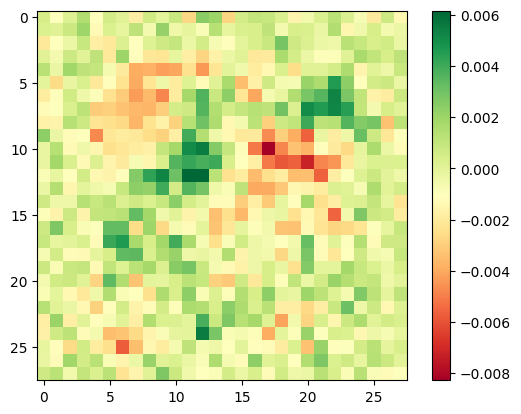

In [368]:
# Let's see how the model thinks it could become even more 5-like
model.set_cost(BinaryCrossEntropyCost())
desired_updates = -get_delta(model, test_image, vectorized_result(5))
plt.imshow(desired_updates)
plt.set_cmap("RdYlGn")
plt.colorbar()


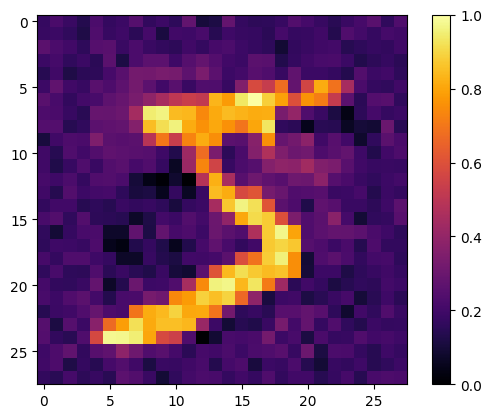

In [375]:
plt.imshow(normalize(test_image - 50 * desired_updates))
plt.set_cmap("inferno")
plt.colorbar()

In [378]:
model.feedforward(np.array([normalize(test_image - 50 * desired_updates)]))

array([[1.04577281e-07],
       [3.38365275e-07],
       [2.92317584e-05],
       [9.99957007e-01],
       [1.07990175e-09],
       [1.11971119e-06],
       [3.13799789e-10],
       [1.73623198e-07],
       [1.09435698e-06],
       [1.09292182e-05]])

Look at that --- Subtracting `50 * desired_updates` decreased our cost enough to get the model confidence up to 99.995%. We can repeat this process of adding gradients to make the model *very* confident that any image is any number. We'll define the `transform()` method to do just that.

In [380]:
def transform(image, target_number, n_steps, update_rate = 0.01, norm=forceNorm):
    for _ in range(n_steps):
        desired_upd = -get_delta(model, image, vectorized_result(target_number))
        desired_upd = desired_upd / np.max(np.abs(desired_updates))
        image = image + update_rate * desired_upd
        image = norm(image)
    return image

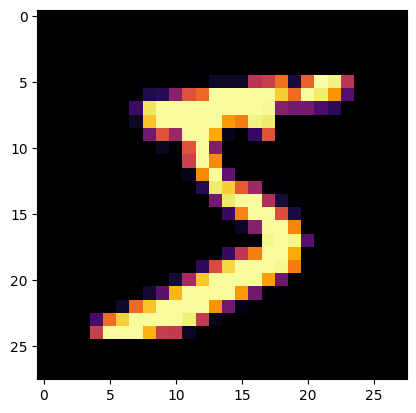

In [419]:
test_image = mnist_train[0][0]
plt.imshow(test_image)

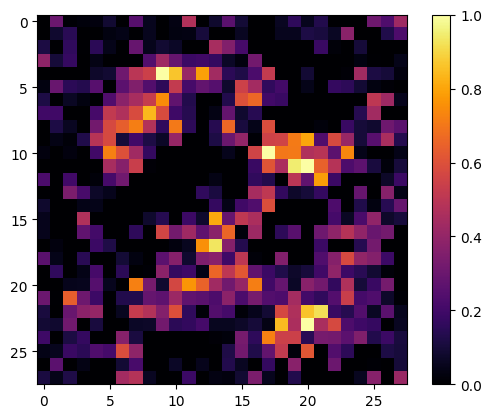

In [422]:
target_num = 2

strengthened_image = test_image
strengthened_image = transform(strengthened_image, target_num, 100, update_rate=0.1, norm=lambda x: pNorm(x))
strengthened_image = forceNorm(strengthened_image)
plt.set_cmap("inferno")
plt.imshow(strengthened_image)
plt.colorbar()

Looking at the regions of highest activation, we can see a broad arc near the top, a diagonal from the top right to the bottom left, and the base of the two near the bottom. There's a lot of noise to be sure, but it seems that our network has learned the key features of what a two is.

Admittedly, this is a cherry picked example and some other target numbers produce results that aren't as interpretable.

In [ ]:
# 99.9993%
model.feedforward(np.array([strengthened_image]))

array([[1.21160554e-08],
       [1.19987000e-08],
       [9.99992997e-01],
       [3.72538250e-07],
       [1.12646919e-12],
       [2.77601567e-10],
       [1.15987895e-09],
       [3.52303987e-09],
       [6.59980623e-06],
       [1.29603722e-09]])

Experimentally, better results are sometimes produced by starting from an arbitrary image, like an image of uniform 0.1 activations. Let's try that:

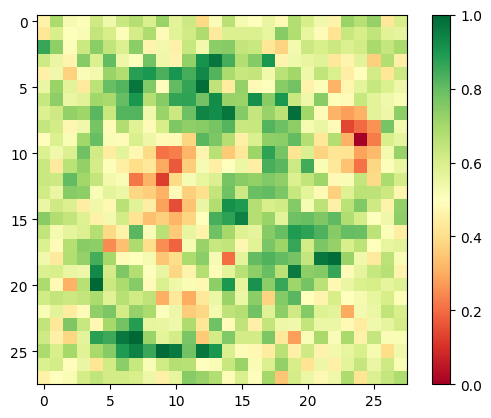

In [481]:
target_num = 3

random_image = 0.1 * np.ones((28, 28))
random_image = transform(random_image, target_num, 100, norm=lambda x: normalize(x))
plt.set_cmap("RdYlGn")
plt.imshow(random_image)
plt.colorbar()

We use a bit of a weird normalization scheme that drives most values up to 0.5. The benefit of this is that we can distinguish which areas the model doesn't really care about from the ones that it specifically drives down.

In the case of a 3, we can see that it actually looks quite a lot like a 3 --- and the red areas, where the model wants the value to go down, are where you would expect no activations if the image were a 3. 

An interesting result of all this is that normalizations do not, usually, seem to impact the model's ability to recognize the image.

In [483]:
model.feedforward(np.array([random_image]))

array([[3.37151209e-07],
       [1.04645486e-06],
       [6.51783322e-05],
       [9.99699982e-01],
       [6.32748679e-07],
       [1.71418277e-07],
       [4.61684198e-07],
       [1.26077578e-05],
       [1.17891871e-04],
       [1.01690290e-04]])